### Part 1: Let's set everything up

#### Importing libraries.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


#### Importing Data.

In [2]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

train = train_df.copy()
test = test_df.copy()
sample = sample_df.copy()
train_test = pd.concat([train,test],axis=0,ignore_index=True)

### Part 2: EDA & Feature Engineering

#### Correlation between some numerical features and the target.

In [3]:
train.corr().Transported.abs().sort_values(ascending=False).drop('Transported',axis=0)

RoomService     0.244611
Spa             0.221131
VRDeck          0.207075
Age             0.075026
FoodCourt       0.046566
ShoppingMall    0.010141
Name: Transported, dtype: float64

<AxesSubplot:>

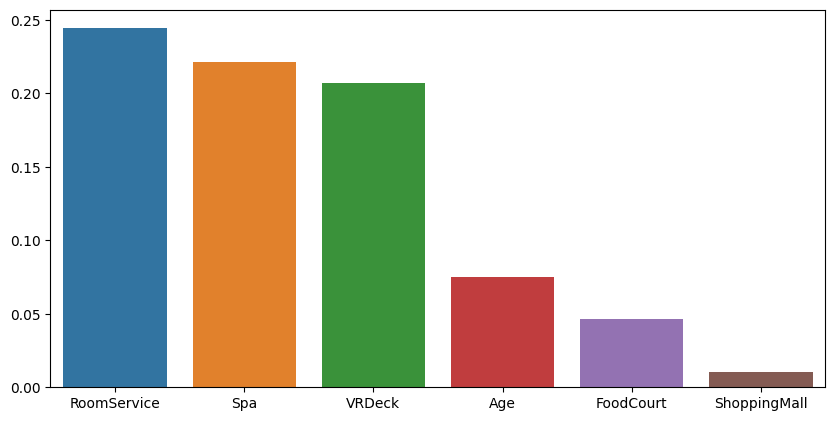

In [4]:
num_fea_imp = train.corr().Transported.abs().sort_values(ascending=False).drop('Transported',axis=0)
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(x=num_fea_imp.index,y=num_fea_imp.values)

#### Let's check out what the traning data looks like.

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

#### There are not many features, let's explore them one by one.

#### First, let's check if the target distribution is balanced.

In [7]:
# Transported 
train.Transported.sum()/len(train)

0.5036236051995858

#### Ok, about half of the passenger were transported. So pretty balanced proportion.
#### Now, let's see how many values are missing for each feature.

In [8]:
train_test.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

#### Every feature has missing values except for 'PassengerID'.

#### Run this cell below to see if we have overlapping Passenger Groups between train and test data.
#### Recall that the first 4 digits of the Passenger ID is their group number.
#### If the result is 0, then no overlapping, meaning that this feature won't probably help too much to the traning process.

In [9]:
# PaggenserID - Is there overlapping of Passenger Groups between train and test data?

train['PassengerGroup'] = train.PassengerId.str.split('_',expand=True)[0].astype('int')
test['PassengerGroup'] = test.PassengerId.str.split('_',expand=True)[0].astype('int')

len(set(train['PassengerGroup'])) + len(set(test['PassengerGroup'])) - len(set(list(train['PassengerGroup'])+list(test['PassengerGroup'])))

0

#### Ok, we will drop the useless features later.
#### Now move on to the 'HomePlanet' feature.
#### Let's fill the null values with 'Unknown'.

In [10]:
# HomePlanet
train['HomePlanet'] = train['HomePlanet'].fillna(value='Unknown')
test['HomePlanet'] = test['HomePlanet'].fillna(value='Unknown')

#### Now the 'CryoSleep' feature.
#### The missing values probably indicate that the person is not really dong cryosleep.
#### Let's just fill them with False.

In [11]:
# CryoSleep
train['CryoSleep'] = train['CryoSleep'].fillna(value=False)
test['CryoSleep'] = test['CryoSleep'].fillna(value=False)

#### The 'CabinDeck' feature is interesing.
#### Since it contains location information, let's try to extract what we can.
#### The 'Cabin' and 'CabinSide' features are created in the cell below.
#### We didn't include a Cabin Number feature because there are way too many values of it.
#### Null values are filled with 'U' for unknown.

In [12]:
# Cabin
train['CabinDeck'] = train['Cabin'].str.split('/',expand=True)[0]
test['CabinDeck'] = test['Cabin'].str.split('/',expand=True)[0]
train['CabinDeck'] = train['CabinDeck'].fillna(value='U')
test['CabinDeck'] = test['CabinDeck'].fillna(value='U')

train['CabinSide'] = train['Cabin'].str.split('/',expand=True)[2]
test['CabinSide'] = test['Cabin'].str.split('/',expand=True)[2]
train['CabinSide'] = train['CabinSide'].fillna(value='U')
test['CabinSide'] = test['CabinSide'].fillna(value='U')

#### Now 'Destination'!
#### First let's map these weird names to some simple letters, because some estimators don't really support rare symbols.
#### Then we fill the null values with 'U' for unknown.

In [13]:
# Destination
dest_dic = {'TRAPPIST-1e':'A','55 Cancri e':'B','PSO J318.5-22':'C'}
train['Destination'] = train['Destination'].map(dest_dic)
train['Destination'] = train['Destination'].fillna(value='U')
test['Destination'] = test['Destination'].map(dest_dic)
test['Destination'] = test['Destination'].fillna(value='U')

#### 'Age' is important.
#### We can group by 'PassengerGroup' and 'HomePlanet' to fill in the null values.
#### I tired both mean and median, and it seems the latter one performes better on this dataset.
#### Let's also create a categorical variable for indicating if the passenger is adult or not.

In [14]:
# Age
train['Age'] = train['Age'].fillna(train.groupby('PassengerGroup')['Age'].transform('median'))
train['Age'] = train['Age'].fillna(train.groupby('HomePlanet')['Age'].transform('median'))

test['Age'] = test['Age'].fillna(test.groupby('PassengerGroup')['Age'].transform('median'))
test['Age'] = test['Age'].fillna(test.groupby('HomePlanet')['Age'].transform('median'))

train['Adult'] = 1
train.loc[train['Age']<18, 'Adult'] = 0

test['Adult'] = 1
test.loc[test['Age']<18, 'Adult'] = 0

#### Nothing crazy here with the 'VIP' feature.
#### It's pretty normal for people who are not VIP to have no records.
#### So let's just fill in null values with False.

In [15]:
# VIP
train['VIP'] = train['VIP'].fillna(value=False)
test['VIP'] = test['VIP'].fillna(value=False)

#### The billing features below are numerical values.
#### Null values probably mean that the passenger did not spend at all (bill = 0).
#### So let's fill in null values with 0.

In [16]:
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(value=0)
test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(value=0)

#### We can also create a 'TotalSpend' feature to add up all the bill amount.

In [17]:
# Total Spend
train['TotalSpend'] = train['RoomService']+train['FoodCourt']+train['ShoppingMall']+train['Spa']+train['VRDeck']
test['TotalSpend'] = test['RoomService']+test['FoodCourt']+test['ShoppingMall']+test['Spa']+test['VRDeck']

#### There might have something interesing with the 'Name' feature.
#### We can extract their family name.
#### Based on their family names, let's create a new feature 'FamilyMember' to count the total of passenger under the same family name.
#### This might related to the 'Transported' result.

In [18]:
# Name
train['FamilyName'] = train['Name'].str.split(' ',expand=True)[1]
train['FamilyName'] = train['FamilyName'].fillna('Unknown')

test['FamilyName'] = test['Name'].str.split(' ',expand=True)[1]
test['FamilyName'] = test['FamilyName'].fillna('Unknown')

train_test['FamilyName'] = train_test['Name'].str.split(' ',expand=True)[1]
train_test['FamilyName'] = train_test['FamilyName'].fillna('Unknown')

family_name_dic = train_test['FamilyName'].value_counts().to_dict()
family_name_dic['Unknown'] = 0

train['FamilyMember'] = train['FamilyName']
train['FamilyMember'] = train['FamilyMember'].map(family_name_dic)

test['FamilyMember'] = test['FamilyName']
test['FamilyMember'] = test['FamilyMember'].map(family_name_dic)

#### Now we drop the extra columns.

In [19]:
train = train.drop(['PassengerId','PassengerGroup','Cabin','Name','FamilyName'],axis=1)
test = test.drop(['PassengerId','PassengerGroup','Cabin','Name','FamilyName'],axis=1)

#### You will get an error at further steps without converting boolean values to integers (0 and 1).

In [20]:
# Convert Bool to Int
train[['CryoSleep','VIP','Transported']] = train[['CryoSleep','VIP','Transported']].astype(int)
test[['CryoSleep','VIP']] = test[['CryoSleep','VIP']].astype(int)

#### Now let's check out what we have now.

In [21]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide,Adult,TotalSpend,FamilyMember
0,Europa,0,A,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P,1,0.0,3
1,Earth,0,A,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S,1,736.0,4
2,Europa,0,A,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S,1,10383.0,7
3,Europa,0,A,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S,1,5176.0,7
4,Earth,0,A,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S,0,1091.0,9


In [22]:
test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Adult,TotalSpend,FamilyMember
0,Earth,1,A,27.0,0,0.0,0.0,0.0,0.0,0.0,G,S,1,0.0,8
1,Earth,0,A,19.0,0,0.0,9.0,0.0,2823.0,0.0,F,S,1,2832.0,4
2,Europa,1,B,31.0,0,0.0,0.0,0.0,0.0,0.0,C,S,1,0.0,6
3,Europa,0,A,38.0,0,0.0,6652.0,0.0,181.0,585.0,C,S,1,7418.0,2
4,Earth,0,A,20.0,0,10.0,0.0,635.0,0.0,0.0,F,S,1,645.0,5


#### Ok, time for feature scaling (numerical features) and encoding (categorical features).

In [23]:
# Feature Scaling
num_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend','FamilyMember']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train[num_features])
test_num_scaled = scaler.transform(test[num_features])

train_num_scaled = pd.DataFrame(data=train_num_scaled,columns=num_features)
test_num_scaled = pd.DataFrame(data=test_num_scaled,columns=num_features)

# Feature Encoding
cat_features = ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinSide','Adult']

train_cat_encoded = pd.get_dummies(train[cat_features],drop_first=True)
test_cat_encoded = pd.get_dummies(test[cat_features],drop_first=True)

#### We need to concatenate the scaled numerical features and the encoded categorical features.

In [24]:
# Train and Test
X = pd.concat([train_num_scaled,train_cat_encoded],axis=1)
X_test = pd.concat([test_num_scaled,test_cat_encoded],axis=1)
y = train.Transported
X_all = pd.concat([X,y],axis=1)

#### After all this, let's check the correlation between the engineered features and the target.

<AxesSubplot:>

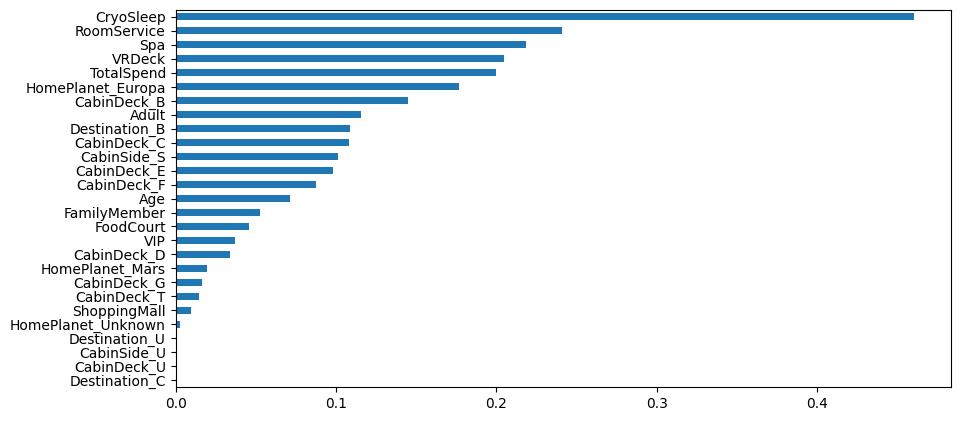

In [25]:
plt.figure(figsize=(10,5),dpi=100)
X_all.corr().Transported.abs().sort_values(ascending=True).iloc[:-1].plot.barh()

#### Seems CryoSleep and the bill amounts are higly correlated to the target.
#### We're ready for modeling now!

### Part 3: Modeling

#### First, let's do a Train Valid Split.
#### I call it 'Train Valid' instead of 'Train Test' to avoid confusion.
#### The Valid dataframe will be used for model evaluation below.
#### The Test dataframe is what we will use for final prediction and submission.

In [26]:
# Train Valid Split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=101)

#### Let's import everthing we will be using.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

#### Run the cell below to find out the best model(s) with their base parameters.

In [ ]:
# Logistic Regression
print('Running LogisticRegression\n')
logreg = LogisticRegression(max_iter = 600)
scores = cross_val_score(logreg,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
logreg_mse = round(abs(scores.mean()), 4)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
logreg_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)


# Decision Tree
print('Running DecisionTreeClassifier\n')
decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
decision_tree_mse = round(abs(scores.mean()), 4)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_valid)
decision_tree_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# Random Forest
print('Running RandomForestClassifier\n')
random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
random_forest_mse = round(abs(scores.mean()), 4)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_valid)
random_forest_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# XGBoost
print('Running XGBClassifier\n')
xgb = XGBClassifier()
scores = cross_val_score(xgb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
xgb_mse = round(abs(scores.mean()), 4)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_valid)
xgb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# GB
print('Running GradientBoostingClassifier\n')
gb = GradientBoostingClassifier()
scores = cross_val_score(gb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
gb_mse = round(abs(scores.mean()), 4)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_valid)
gb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# LightGBM
print('Running LGBMClassifier\n')
lgbm = LGBMClassifier()
scores = cross_val_score(lgbm,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
lgbm_mse = round(abs(scores.mean()), 4)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_valid)
lgbm_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# Catboost
print('Running CatBoostClassifier\n')
catb = CatBoostClassifier(verbose = 0)
scores = cross_val_score(catb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
catb_mse = round(abs(scores.mean()), 4)
catb.fit(X_train, y_train)
y_pred = catb.predict(X_valid)
catb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# Histogram-based Gradient Boosting Classification Tree
print('Running HistGradientBoostingClassifier\n')
hgb = HistGradientBoostingClassifier()
scores = cross_val_score(hgb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
hgb_mse = round(abs(scores.mean()), 4)
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_valid)
hgb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

model_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GB', 'LightGBM', 'Catboost', 'HistBoost'],
    'Train MSE': [logreg_mse, decision_tree_mse, random_forest_mse, xgb_mse, gb_mse, lgbm_mse, catb_mse, hgb_mse],
    'Validation Accuracy': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gb_acc, lgbm_acc, catb_acc, hgb_acc]
})

print(model_df.sort_values('Validation Accuracy', ascending = False).reset_index(drop = True))

#### Seems Catboost is one of the best option here with low Train MSE and high Validation Accuracy.
#### Let's run a Grid Search on it to further tune the hyper parameters.
#### Note that it might take several minutes to run the cell below.
#### If you're eager knowing the result, skip to the cell after.

In [ ]:
#  Grid Search on Catboost
catb = CatBoostClassifier(verbose = 0)
param_grid = {'iterations':[300,400,500,1000],
              'learning_rate':[0.01,0.03,0.05,0.07,0.09],
              'depth':[2,5,10]
             }

grid = GridSearchCV(estimator=catb, param_grid=param_grid, cv=5)
grid.fit(X,y)
print('Mean accuracy:',grid.score(X,y))
print('Best hyperparameters:',grid.best_params_)

#### Here we instantiate a Catboost model with tuned hyper parameters

In [ ]:
# Tuned Catboost
catb = CatBoostClassifier(depth=5,iterations=300,learning_rate=0.05,verbose=0)

#### Let's make a prediction and submit our result!

In [ ]:
# Submitting
model=catb
model.fit(X,y)
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': predictions})
output['Transported'] = output['Transported'].astype('bool')
output.to_csv('submission.csv', index=False)

#### Are you happy with the result?

#### Please upvote to support my work : )